In [ ]:
!pip uninstall pandas

!pip install pandas==1.1.5

Found existing installation: pandas 1.3.5
Uninstalling pandas-1.3.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.3.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 5.2 MB/s 


#SuperTrend

In [ ]:
def SuperTrend (A) :

  A['TR'] = pd.Series(dtype = 'float64', index=None)
  A['TR'][0] = 0

  for i in range(1,len(A)) :
    A['TR'][i] = max( (A['High'][i] - A['Low'][i]), abs(A['High'][i] - A['Close'][i-1]), abs(A['Low'][i] - A['Close'][i-1]) )

  n = 10
  ma = A['TR'].rolling(window=n).mean()
  
  A['ATR'] = pd.DataFrame(ma)

  Multiplier = 3

  A['Basic_ub'] = ( A['High'] + A['Low']) / 2 + A['ATR']*Multiplier
  A['Basic_lb'] = ( A['High'] + A['Low']) / 2 - A['ATR']*Multiplier

  A['F_ub'] = pd.Series(dtype = 'float64', index=None)
  A['F_lb'] = pd.Series(dtype = 'float64', index=None)

# Final Upper Band (Sell Line)

  for i in range(len(A)) :
    if i < n :
      A['F_ub'][i] = 0

    elif A['Basic_ub'][i] < A['F_ub'][i-1] or A['Close'][i-1] > A['F_ub'][i-1] :
      A['F_ub'][i] = A['Basic_ub'][i]

    else :
      A['F_ub'][i] = A['F_ub'][i-1]

  # Buy Line
  for i in range(len(A)) :

    if i < n :
      A['F_lb'][i] = 0

    else :
      if A['Basic_lb'][i] > A['F_lb'][i-1] or A['Close'][i-1] < A['F_lb'][i-1] :
        A['F_lb'][i] = A['Basic_lb'][i]
      else :
        A['F_lb'][i] = A['F_lb'][i-1]

  A['ST'] = pd.Series(index=None)

  for i in range(len(A)) :
    
    if i < n :
      A['ST'][i] = 0
  
    elif A['ST'][i-1] == A['F_ub'][i-1] and A['Close'][i] <= A['F_ub'][i] :
        A['ST'][i] = A['F_ub'][i]
    elif A['ST'][i-1] == A['F_ub'][i-1] and A['Close'][i] >  A['F_ub'][i] :
        A['ST'][i] = A['F_lb'][i]
    elif A['ST'][i-1] == A['F_lb'][i-1] and A['Close'][i] >= A['F_lb'][i] :
        A['ST'][i] = A['F_lb'][i]
    elif A['ST'][i-1] == A['F_lb'][i-1] and A['Close'][i] <  A['F_lb'][i] :
        A['ST'][i] = A['F_ub'][i]

    # Buy or Sell indicator

  A['Buy_Sell'] = pd.Series(index=None, dtype=object)

  for k in range(len(A)) :

    if k == 0 :
      A['Buy_Sell'][k] = "NA"
    
    elif A['ST'][k] < A['Close'][k] :
      A['Buy_Sell'][k] = "BUY"
    else :
      A['Buy_Sell'][k] = "SELL"

  A['BUY'] = A['ST'].copy()
  A['SELL'] = A['ST'].copy()

  for i in range(len(A)) :

    if A['Buy_Sell'][i] == 'BUY' :
      A['SELL'][i] = None
    elif A['Buy_Sell'][i] == 'SELL' :
      A['BUY'][i] = None


  A['ST_sign'] = pd.Series(index=None, dtype = 'int64')

  for i in range(len(A)) :

    if A['BUY'][i] :
      A['ST_sign'][i] = 0

    else :
      A['ST_sign'][i] = 1

# 새 섹션

# RSI

In [ ]:
def SMA(data, period=5, column='Close'):
  return data[column].rolling(window=period).mean()
def RSI(data, period = 14, column = 'Close'):
  delta = data[column].diff(1)
  delta = delta.dropna() # or delta[1:]    #변화량을 구할 수 없는 값(초반n개)은 쳐내기

  up =  delta.copy()  # delta 값 복사
  down = delta.copy() # delta 값 복사
  up[up < 0] = 0 
  down[down > 0] = 0 
  data['up'] = up
  data['down'] = down

  AVG_Gain = SMA(data, period, column='up')   #상승폭 평균 (data column이 up일때)
  AVG_Loss = abs(SMA(data, period, column='down')) #하락폭 평균(sma)
  RS = AVG_Gain / AVG_Loss

  RSI = 100.0 - (100.0/ (1.0 + RS))
  data['RSI'] = RSI

  return data

In [ ]:
def adj_RSI(r):
  r['RSI'] = RSI(r)['RSI']
  r['RSI_diff'] = r['RSI'].diff(1)
  append_RSI = []
  for a in range(len(r)):
    if r['RSI'][a]<35 and (r['RSI'][a] - r['RSI_diff'][a])>=35: #현재 RSI가 30보다 큰 상태 -> 30보다 작은 상태로 바뀌는현상을 탐지하기 위해 위에서 RSI_diff 컬럼을 생성했고 현재 RSI와의 차(-)를 통해 30구간 돌파를 감지 
      append_RSI.append(1)   #append_RSI 에 30의 값을 추가
    elif r['RSI'][a]>65 and (r['RSI'][a] - r['RSI_diff'][a])<=65:    #마찬가지로 현재 RSI가 70보다 작은 상태 -> 70보다 큰 상태로 바뀌는 현상(70구간 돌파) 를 감지하여 append_RSI에 10을 추가
      append_RSI.append(0)
    else:
      append_RSI.append(2)    #돌파가 일어나지 않는 구간은 전부 0으로 설정
  r['appended_RSI'] = append_RSI  #기존 테이블에 추가

# EMA

In [ ]:
#지수이동평균(EMA) 20일 평균
def EMA(df, period=20, column='Close'):
  return df[column].ewm(span=period, adjust=False).mean()


#MACD

In [ ]:
def MACD(df, period_long=26, period_short=12, period_signal=9, column='Close'):
  ShortEMA = EMA(df, period_short, column=column)

  LongEMA = EMA(df, period_long, column=column)

  df['MACD'] = ShortEMA - LongEMA

  df['Signal_Line'] = EMA(df, period_signal, column='MACD')

In [ ]:
def MACD_strategy(r):    
  MACD_signal = [] #Buy(0),Sell(1),Hold(2)

  for i in range(len(r)):
      if r['MACD'][i] > r['Signal_Line'][i] and r['MACD'][i-1] <= r['Signal_Line'][i-1]: #매수전략 (MACD > Signal Line):
        MACD_signal.append(0) #매수(Buy) : 0
      elif r['MACD'][i] < r['Signal_Line'][i] and r['MACD'][i-1] >= r['Signal_Line'][i-1]: #매도전략 (MACD < Signal Line)
        MACD_signal.append(1) #매도(Sell) : 1
      else:
        MACD_signal.append(2) #Hold : 2 (MACD와 Signal Line의 교차점)
  r['MACD_signal'] = MACD_signal


#OBV

In [ ]:
def OBV(r):
  OBV= []
  OBV.append(0)
  for i in range(1,len(r.Close)):
  #오늘 종가가 어제 종가보다 높을 때
     if r.Close[i] > r.Close[i-1]:
  # 오늘 OBV = 어제 OBV + 오늘 거래량(Volume)
       OBV.append(OBV[-1] + r.Volume[i])
  #오늘 종가가 어제 종가보다 낮을 때 
     elif r.Close[i] < r.Close[i-1]:
  # 오늘 OBV = 어제 OBV - 오늘 거래량(Volume)
       OBV.append(OBV[-1] - r.Volume[i])
  # 오늘 종가 = 어제 종가 (주가변동 X)
     else:
  # 오늘 OBV = 어제 OBV
       OBV.append(OBV[-1])
  r['OBV'] = OBV


In [ ]:
#OBV_EMA(20일 기준)
def OBV_EMA(r):
  r['OBV_EMA'] = r['OBV'].ewm(com=20).mean()

In [ ]:
def OBV_strategy(r):
  OBV_signal = [] #Buy(0),Sell(1),Hold(2)

  for i in range(len(r)):

    if r['OBV'][i] > r['OBV_EMA'][i] and r['OBV'][i-1] <= r['OBV_EMA'][i-1]:
      OBV_signal.append(0) #매수(Buy) : 0
    elif r['OBV'][i] < r['OBV_EMA'][i] and r['OBV'][i-1] >= r['OBV_EMA'][i-1]:
      OBV_signal.append(1) #매도(Sell) : 1
    else:
      OBV_signal.append(2) #Hold : 2
  r['OBV_signal'] = OBV_signal

# BB - MFI

In [ ]:
def BB(r):
  r['SMA20'] = r['Close'].rolling(window=20).mean() # 20일 이동평균
  r['stddev'] = r['Close'].rolling(window=20).std() # 20일 이동표준편차
  r['upper'] = r['SMA20'] + 2*r['stddev'] # 상단밴드
  r['lower'] = r['SMA20'] - 2*r['stddev'] # 하단밴드

In [ ]:
def BB_MFI(r):
    #%b : 주가가 볼린저 밴드의 어느 지점에 위치하는지 나타내는 지표
    #%b = (종가-하단 볼린저밴드)/(상단 볼린저밴드-하단 볼린저밴드)
    r['PB']= (r['Close'] - r['lower'])/(r['upper'] - r['lower'])
    # 중심가격 = 일정 기간의 (고가 + 저가 + 종가)/3
    r['TP'] = (r['High'] + r['Low'] + r['Close'])/3
    r['PMF'] = 0 #긍정적 현금흐름 : 전 영업일보다 중심가격 상승 시 현금흐름
    r['NMF'] = 0 #부정적 현금흐름 : 전 영업일보다 중심가격 하락 시 현금흐름
    r['TP_diff'] = r['TP'].diff(1)
    #현금 흐름 = 중심가격(TP) * 거래량(Volume)
    for i in range(len(r)):
      #당일의 중심가격이 전일의 중심가격보다 크면 긍정적 현금흐름
      if 0 < r['TP_diff'][i]:
        r['PMF'][i] = r['TP'][i]*r['Volume'][i]
        r['NMF'][i] = 0
      #당일의 중심가격이 전일의 중심가격보다 작거나 같으면 부정적 현금흐름
      else:
        r['NMF'][i] = (r['TP'][i])*(r['Volume'][i])
        r['PMF'][i] = 0
    r['MFR'] = r.PMF.rolling(10).sum()/r.NMF.rolling(10).sum()
    #MFI = 100 - (100 / 1 + (일정기간(10일) 긍정적 현금 흐름(PMF)의 합/ 일정기간 부정적 현금 흐름(NMF)의 합))
    r['MFI10'] = 100 - (100 / (1 + r['MFR']))
    BB_MFI_signal = []
    for i in range(len(r)): 
      if float(r['PB'][i])>=0.8 and r['MFI10'][i]>=80 : #매수(Buy) : 0
        BB_MFI_signal.append(0)
      elif float(r['PB'][i])<=0.2 and r['MFI10'][i]<= 20 : #매도(Sell) : 1
        BB_MFI_signal.append(1)
      else:
        BB_MFI_signal.append(2) #Hold : 2
    r['BB_MFI_signal'] = BB_MFI_signal


# EFI(RSI기반)

In [ ]:
def Force_id_1(data):
    ForceIndex=pd.Series(data['Close'].diff(1)* data['Volume'],name='Force_ID')
    data['EFI_1_13'] = ForceIndex.ewm(13).mean()

def RSI_EFI_Cross(r):
  Force_id_1(r)
  RSI_EFI_cross = []
  r['EFI_1_13_diff'] = r['EFI_1_13'].diff(1)
  for a in range(len(r)):
    if r['RSI_diff'][a] < 0 and (r['EFI_1_13'][a]<0) and (abs(r['EFI_1_13'][a]) < abs(r['EFI_1_13_diff'][a])) :
      RSI_EFI_cross.append(0)
    elif r['RSI_diff'][a] > 0 and (r['EFI_1_13'][a]>0) and (abs(r['EFI_1_13'][a]) < abs(r['EFI_1_13_diff'][a])) :
      RSI_EFI_cross.append(1)
    else:
      RSI_EFI_cross.append(2)
  r['RSI_EFI_cross'] = RSI_EFI_cross

# Volume Change

In [ ]:
from collections import defaultdict
def volume_change (df) :
  df['V_change'] = df['Volume'].shift(1)
  df['V_change'] = ( df['Volume'] - df['V_change'] ) / df['V_change'] 
  
    
  # df['V_change'] = df['V_change'].astype(object)

  # for i in range(len(df)) :
  #   if df['V_change'][i] > 0 :
  #     df['V_change'][i] = 1
  #   elif df['V_change'][i] < 0 :
  #     df['V_change'][i] = 0
  #   elif df['V_change'][i] > -0.0003 and df['V_change'][i] < 0.0003 :
  #     df['V_change'][i] = 2

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.1 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# SOX

In [ ]:
import yfinance as yf
sox = yf.download('^SOX',start = "2000-01-01",end="2022-05-30")
sox['change']=sox['Close'].diff(1)
sox.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,change
Date,,,,,,,
2000-01-03,704.559998,713.969971,684.799988,713.200012,712.855103,0,NaN
2000-01-04,713.200012,713.200012,686.280029,687.320007,686.987610,0,-25.880005
2000-01-05,685.950012,690.119995,662.890015,678.539978,678.211792,0,-8.780029
2000-01-06,678.539978,683.619995,662.619995,669.330017,669.006287,0,-9.209961
2000-01-07,669.330017,690.820007,662.440002,690.750000,690.415955,0,21.419983


In [ ]:
#수정된 SOX함수 (필라델피아 반도체지수)
def sox_trend(r):
  sox_trend = []
  for a in range(len(r)):
    if a>1 and sox['change'][a]>0 and (sox['change'][a])*(sox['change'][a-1])<0 and sox['change'][a-1]<=((sox['Close'][a-2])*(-0.043)):
      sox_trend.append(0)
    elif a>1 and sox['change'][a]>0 and (sox['change'][a])*(sox['change'][a-1])<0 and sox['change'][a-1]>=((sox['Close'][a-2])*(-0.043)):
      sox_trend.append(1)
    elif a>0 and (sox['change'][a])<0 and (sox['change'][a])*(sox['change'][a-1])>0 and (sox['change'][a])<=((sox['Close'][a-1])*(-0.043)):
      sox_trend.append(0)
    else:
      sox_trend.append(2)
  r['sox_trend'] = sox_trend

# USDX

In [ ]:
import yfinance as yf
usdf = yf.download('DX-Y.NYB',start = "2002-01-01",end="2022-05-30")
usdf['change']=usdf['Close'].diff(1)

[*********************100%***********************]  1 of 1 completed


In [ ]:
def USDX_trend(r):
  USDX = []
  USDX.append(2)
  for a in range(len(r)):
    if usdf['change'][a] >= 0.21:
     USDX.append(1)
    elif usdf['change'][a] <= -0.23:
      USDX.append(0)
    else:
      USDX.append(2)
  del USDX[-1]
  r['USDX'] = USDX



# Candle Stick



In [ ]:
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0)) #전체 shape (1,1) / 위치 (0,0)에 그래프를 그려라 
    closep=dataset['Close'] #Close column
    highp=dataset['High'] #High column
    lowp=dataset['Low'] #Low column
    openp=dataset['Open'] #Open column
    date=range(len(closep)) #column 길이 범위 [0-99]

    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me) 
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f') #candle stick 그래프
    for label in ax1.xaxis.get_ticklabels(): #x축의 개별 ticklabels를 가져옴 
        label.set_rotation(45) #xlabel 45도 기울여라
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10)) #10보다 작은 눈금 수 
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0) #subplot 4면의 위치 조정(left, bottom, right, top) / subplot 간의 간격을 위해 각각 figure의 너비와 높이에 대한 비율 조절 (hspace, wspace)
    plt.show()

def my_generator(data,lookback): #generator 함수 (촛불 시퀀스의 3D 배열을 생성하는 사용자 정의 함수)
    data = data[['Open','High','Low','Close']].values[1:]
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int) #항목을 초기화하지 않고 주어진 모양과 유형의 새 배열을 반환 / shape : (1,lookback,4) / dtype : int
    for a in range(len(data)-lookback): 
        temp_list = []
        for i in data[first_row:first_row+lookback] :
            temp_list.append(i)
        temp_list2 = np.asarray(temp_list) #temp_list Numpy 배열로 변환
        templist3 = [temp_list2] #temp_list2를 list 형태로 
        templist4 = np.asarray(templist3) 
        arr = np.append(arr, templist4, axis=0) #append(배열1,배열2,축) 이어 붙이기
        first_row=first_row+1
    return arr

def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:   # Close > Open 
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]     # High - Close
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000,2)
    candlestick_data[2]=round(round(wicks_down,5)*10000,2)
    candlestick_data[3]=round(round(body_size,5)*10000,2)

    return candlestick_data

def my_generator_candle(data,lookback):
    data = data[['Open','High','Low','Close']].values[1:]
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for i in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(i)
            temp_list.append(converted_data)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

def my_generator_candle_X_Y(data,lookback,MinMax = False):
    data = data[['Open','High','Low','Close']].values[1:]
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))
    arr3 = np.empty((0,lookback,4))
    Y_list = []
    for a in range(len(data)-lookback):
        temp_list = []
        temp_list_raw = []
        for i in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(i)  
            temp_list.append(converted_data)
            temp_list_raw.append(i)
        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)

        if MinMax==True:
            templist99 = scaler.fit_transform(templist4[0])
            arr = np.append(arr, [templist99], axis=0)
        else:
            arr = np.append(arr, templist4, axis=0)

        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)

        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
        Prediction = converted_data_prediction[0]
        Y_list.append(Prediction)

        first_row=first_row+1

    arr2 = np.asarray(Y_list)

    return arr,arr2,arr3   


def graph_data_ohlc2(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0)) #전체 shape (1,1) / 위치 (0,0)에 그래프를 그려라 
    closep=dataset[:,[3]] #Close column
    highp=dataset[:,[1]] #High column
    lowp=dataset[:,[2]] #Low column
    openp=dataset[:,[0]] #Open column
    date=range(len(closep)) #column 길이 범위 [0-99]

    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me) 
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f') #candle stick 그래프
    for label in ax1.xaxis.get_ticklabels(): #x축의 개별 ticklabels를 가져옴 
        label.set_rotation(45) #xlabel 45도 기울여라
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10)) #10보다 작은 눈금 수 
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0) #subplot 4면의 위치 조정(left, bottom, right, top) / subplot 간의 간격을 위해 각각 figure의 너비와 높이에 대한 비율 조절 (hspace, wspace)
    plt.show()
    

# 계산

## 필요한 Module

In [ ]:
!pip install finance-datareader
!pip install shap
!pip install mpl_finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from google.colab import files
import FinanceDataReader as fdr
import pandas_datareader.data as web
from mpl_finance import candlestick_ohlc

## step.1

In [ ]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5138 entries, 2002-01-02 to 2022-05-27
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          5138 non-null   float64
 1   Open           5138 non-null   float64
 2   High           5138 non-null   float64
 3   Low            5138 non-null   float64
 4   Volume         5138 non-null   float64
 5   Change         5138 non-null   float64
 6   up             5137 non-null   float64
 7   down           5137 non-null   float64
 8   RSI            5124 non-null   float64
 9   RSI_diff       5123 non-null   float64
 10  appended_RSI   5138 non-null   int64  
 11  TR             5138 non-null   float64
 12  ATR            5129 non-null   float64
 13  Basic_ub       5129 non-null   float64
 14  Basic_lb       5129 non-null   float64
 15  F_ub           5138 non-null   float64
 16  F_lb           5138 non-null   float64
 17  ST             5138 non-null   flo

In [ ]:
USDX_trend(apple)

In [ ]:
apple = fdr.DataReader('AAPL','20020101','20220530')

In [ ]:
apple['Close'].max()

182.01

In [ ]:
SMA(apple)
RSI(apple)
adj_RSI(apple)
SuperTrend(apple)
EMA(apple)
MACD(apple)
MACD_strategy(apple)
OBV(apple)
OBV_EMA(apple)
OBV_strategy(apple)
BB(apple)
BB_MFI(apple)
Force_id_1(apple)
RSI_EFI_Cross(apple)
volume_change(apple)
sox_trend(apple)

In [ ]:
USDX_trend(apple)

IndexError: ignored

In [ ]:
adj_RSI(apple)

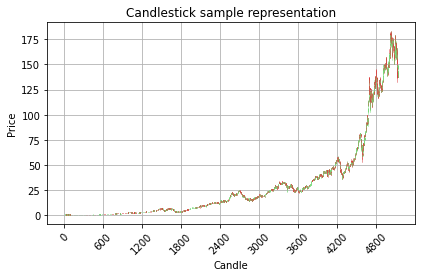

In [ ]:
graph_data_ohlc(apple)

In [ ]:
C,T, C_raw = my_generator_candle_X_Y(apple,3)

In [ ]:
C2 = pd.DataFrame(C[:,0])
C2.columns = ['candle_type','bottom', 'top', 'body']
C2.head()

,candle_type,bottom,top,body
0,1.0,0.0,0.0,100.0
1,0.0,100.0,100.0,100.0
2,0.0,100.0,0.0,200.0
3,0.0,0.0,0.0,100.0
4,0.0,0.0,100.0,200.0


In [ ]:
apple['candle_type'] = pd.Series(index=None, dtype ='int64')
apple['bottom'] = pd.Series(index=None, dtype ='float64')
apple['top'] = pd.Series(index=None, dtype ='float64')
apple['body'] = pd.Series(index=None, dtype ='float64')


for k in range(1,len(C2)+1) :
  apple['candle_type'][k] = C2['candle_type'].iloc[k-1]
  apple['bottom'][k] = C2['bottom'].iloc[k-1]
  apple['top'][k] = C2['top'].iloc[k-1]
  apple['body'][k] = C2['body'].iloc[k-1]

In [ ]:
C2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5134 entries, 0 to 5133
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   candle_type  5134 non-null   float64
 1   bottom       5134 non-null   float64
 2   top          5134 non-null   float64
 3   body         5134 non-null   float64
dtypes: float64(4)
memory usage: 160.6 KB


In [ ]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5138 entries, 2002-01-02 to 2022-05-27
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          5138 non-null   float64
 1   Open           5138 non-null   float64
 2   High           5138 non-null   float64
 3   Low            5138 non-null   float64
 4   Volume         5138 non-null   float64
 5   Change         5138 non-null   float64
 6   up             5137 non-null   float64
 7   down           5137 non-null   float64
 8   RSI            5124 non-null   float64
 9   RSI_diff       5123 non-null   float64
 10  appended_RSI   5138 non-null   int64  
 11  TR             5138 non-null   float64
 12  ATR            5129 non-null   float64
 13  Basic_ub       5129 non-null   float64
 14  Basic_lb       5129 non-null   float64
 15  F_ub           5138 non-null   float64
 16  F_lb           5138 non-null   float64
 17  ST             5138 non-null   flo

In [ ]:
apple['PrevClose'] = apple['Close'].shift(1) 

In [ ]:
apple = apple[1:]

In [ ]:
#나중에 특성선택을 위해 정답라벨을 만들어준다. (등락률)
apple['Return'] = (apple['Close'] - apple['PrevClose']) / apple['PrevClose']

In [ ]:
# 학습을 위해 1,0으로 바꿔주기
Buy_Sell2 = []
for i in apple['Buy_Sell']:
  if i == 'BUY':
    Buy_Sell2.append(1)
  else:
    Buy_Sell2.append(0)
apple['Buy_Sell'] = Buy_Sell2

In [ ]:
apple['Buy_Sell'] = apple['Buy_Sell'].astype(int)

In [ ]:
apple['pred'] = apple['Return'].ewm(5).mean().shift(-5)

In [ ]:
apple = apple[:-5]

In [ ]:
apple.isnull().sum()

Close               0
Open                0
High                0
Low                 0
Volume              0
Change              0
up                  1
down                1
RSI                14
RSI_diff           15
appended_RSI        0
TR                  0
ATR                 9
Basic_ub            9
Basic_lb            9
F_ub                0
F_lb                0
ST                  0
Buy_Sell            0
BUY              2080
SELL             3057
ST_sign             0
MACD                0
Signal_Line         0
MACD_signal         0
OBV                 0
OBV_EMA             0
OBV_signal          0
SMA20              19
stddev             19
upper              19
lower              19
PB                 19
TP                  0
PMF                 0
NMF                 0
TP_diff             1
MFR                 9
MFI10               9
BB_MFI_signal       0
EFI_1_13            1
EFI_1_13_diff       2
RSI_EFI_cross       0
V_change            1
sox_trend           0
USDX      

In [ ]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 475 entries, 2000-02-01 to 2001-12-21
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          475 non-null    float64
 1   Open           475 non-null    float64
 2   High           475 non-null    float64
 3   Low            475 non-null    float64
 4   Volume         475 non-null    float64
 5   Change         475 non-null    float64
 6   up             475 non-null    float64
 7   down           475 non-null    float64
 8   RSI            475 non-null    float64
 9   RSI_diff       475 non-null    float64
 10  appended_RSI   475 non-null    int64  
 11  TR             475 non-null    float64
 12  ATR            475 non-null    float64
 13  Basic_ub       475 non-null    float64
 14  Basic_lb       475 non-null    float64
 15  F_ub           475 non-null    float64
 16  F_lb           475 non-null    float64
 17  ST             475 non-null    floa

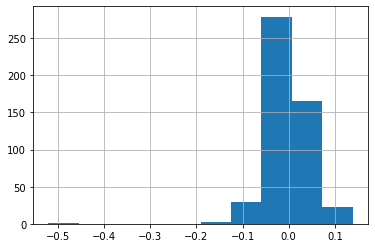

In [ ]:
# 새로 만든 "등락률" 변수의 분포를 시각화 해 보자
apple['Return'].hist()

#0을 기준으로 크게 벗어나지 않는다

In [ ]:
apple['pred'].mean()

-0.0005040739147277285

In [ ]:
np.median(apple['pred'])

nan

In [ ]:
apple['pred'].max()

0.033481447167044195

In [ ]:
np.quantile(apple['pred'], .75)

0.008744202648679991

In [ ]:
np.quantile(apple['pred'], .25)

-0.007373666675241876

In [ ]:
np.quantile(apple['pred'], .75)-np.quantile(apple['pred'], .25)

0.01611786932392187

In [ ]:
apple['pred'].min()

-0.08732182171193255

In [ ]:
apple['pred2'] = pd.Series(index=None, dtype = object)

for i in range(len(apple)) :
  if apple['pred'][i] > 0.009 :
    apple['pred2'][i] = 1

  elif apple['pred'][i] < -0.007 :
    apple['pred2'][i] = 0
    
  elif apple['pred'][i] >= -0.007 and apple['pred'][i] <= 0.009 :
    apple['pred2'][i] = 2

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, apple['pred2'],
    random_state=0,
    test_size=0.2
)

ValueError: ignored

In [ ]:
apple['Change'] = apple['Close'].diff(1)

In [ ]:
apple = apple[19:]

In [ ]:
#NAN값 확인
apple.isnull().sum()

Close               0
Open                0
High                0
Low                 0
Volume              0
Change              0
up                  0
down                0
RSI                 0
RSI_diff            0
appended_RSI        0
TR                  0
ATR                 0
Basic_ub            0
Basic_lb            0
F_ub                0
F_lb                0
ST                  0
Buy_Sell            0
BUY              2071
SELL             3048
ST_sign             0
MACD                0
Signal_Line         0
MACD_signal         0
OBV                 0
OBV_EMA             0
OBV_signal          0
SMA20               0
stddev              0
upper               0
lower               0
PB                  0
TP                  0
PMF                 0
NMF                 0
TP_diff             0
MFR                 0
MFI10               0
BB_MFI_signal       0
EFI_1_13            0
EFI_1_13_diff       0
RSI_EFI_cross       0
V_change            0
sox_trend           0
USDX      

In [ ]:
y = y.astype(int)

In [ ]:
apple = apple.drop(['BUY','SELL'],axis=1)

In [ ]:
apple.isnull().sum()

In [ ]:
apple = apple.drop(['MFR'], axis=1)

******특성선택    특성선택******

In [ ]:
from sklearn.model_selection import train_test_split
X = apple[apple.columns.difference(['pred','pred2'])]
y = apple['pred2']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2)

In [ ]:
apple['pred2'] = apple['pred2'].astype(int)

In [ ]:
from sklearn.model_selection import train_test_split
X = apple[apple.columns.difference(['pred','pred2'])]
y = apple['pred2']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4091, 49)
(1023, 49)
(4091,)
(1023,)


In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
# SelectKBest 모듈을 통한 특성선택 (20개)
from sklearn.feature_selection import f_regression, SelectKBest
selector = SelectKBest(score_func=f_regression, k=20)

In [ ]:
#MFR 제거 나중에 다시 확인 (float값이 아닌 값이 들어있는듯?)
del apple['MFR']

In [ ]:
for i in apple['MFR']:
  if type(i) != float:
    print(apple['MFR'][i])

In [ ]:
try:
  X_train_selected = selector.fit_transform(X_train,y_train)
except ZeroDivisionError:
  print("ZeroDivision")

ZeroDivision


In [ ]:
X.shape

(469, 49)

In [ ]:
X['PMF'].mean()

111580343.84221749

In [ ]:
y = y.astype(int)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

In [ ]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  

array([0.02674659, 0.00578605, 0.02192117, 0.02172253, 0.01215124,
       0.01687374, 0.0182971 , 0.03572094, 0.01966628, 0.02220558,
       0.02401879, 0.02171621, 0.02010831, 0.03352936, 0.00782189,
       0.02831567, 0.01509649, 0.02224524, 0.0297872 , 0.0095835 ,
       0.01696396, 0.03439207, 0.01322754, 0.0204361 , 0.03754684,
       0.01122507, 0.02156621, 0.01647595, 0.03159225, 0.02763964,
       0.        , 0.03734112, 0.02238601, 0.01817983, 0.01481416,
       0.01735377, 0.02040137, 0.02011845, 0.00991232, 0.01669442,
       0.01507019, 0.01172884, 0.01207447, 0.02744057, 0.0155941 ,
       0.03512585, 0.01650415, 0.00978938, 0.03509153])

In [ ]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape   

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


(469, 22)

In [ ]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,stratify=y,
    test_size = 0.2,
    random_state = 10 )

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)

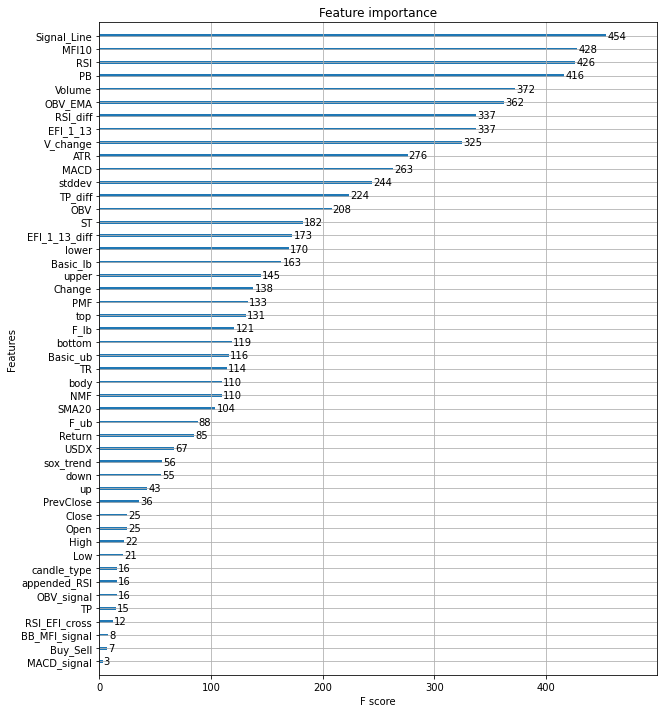

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)

In [ ]:
def get_clf_eval(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print('정확도:\n', accuracy)

In [ ]:
get_clf_eval(y_test, w_preds)

정확도:
 0.648936170212766


In [ ]:
get_clf_eval(y_test, w_preds)

정확도:
 0.823069403714565


In [ ]:
apple2 = apple[15:]

In [ ]:
apple3 = apple2[:-5]

In [ ]:
apple['MFR'].mean()

inf

In [ ]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 494 entries, 2000-01-04 to 2001-12-21
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          494 non-null    float64
 1   Open           494 non-null    float64
 2   High           494 non-null    float64
 3   Low            494 non-null    float64
 4   Volume         494 non-null    float64
 5   Change         494 non-null    float64
 6   up             494 non-null    float64
 7   down           494 non-null    float64
 8   RSI            481 non-null    float64
 9   RSI_diff       480 non-null    float64
 10  appended_RSI   494 non-null    int64  
 11  TR             494 non-null    float64
 12  ATR            486 non-null    float64
 13  Basic_ub       486 non-null    float64
 14  Basic_lb       486 non-null    float64
 15  F_ub           494 non-null    float64
 16  F_lb           494 non-null    float64
 17  ST             494 non-null    floa

In [ ]:
apple['Buy_Sell'].unique()

array([1, 0])

In [ ]:
apple3 = apple3.drop(['TP_diff','EFI_1_13_diff'],axis=1)

In [ ]:
apple['pred'] = apple['Change'].ewm(5).mean().shift(-5)

In [ ]:
#pred의 통계 (평균, 표준편차)

In [ ]:
import numpy as np
np.median(apple['pred'])

0.00389700194808687

In [ ]:
apple = apple.dropna(axis=0)

In [ ]:
apple['pred2'] = pd.Series(index=None, dtype = object)

for i in range(len(apple)) :
  if apple['pred'][i] > 0.062 :
    apple['pred2'][i] = 1

  elif apple['pred'][i] < 0.008 :
    apple['pred2'][i] = 0
    
  elif apple['pred'][i] >= 0.008 and apple['pred'][i] <= 0.062 :
    apple['pred2'][i] = 2

NameError: ignored

In [ ]:
apple3[:2]

,Close,Open,High,Low,Volume,Change,up,down,RSI,RSI_diff,...,EFI_1_13,RSI_EFI_cross,V_change,sox_trend,candle_type,bottom,top,body,pred,pred2
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-25,1.00,0.94,1.01,0.91,497200000.0,0.05,0.05,0.00,56.896552,10.994912,...,1.019994e+07,2,0.127463,1,1.0,100.0,300.0,600.0,-0.007889,0
2000-01-26,0.98,0.98,1.02,0.98,367160000.0,-0.02,0.00,-0.02,54.237288,-2.659264,...,8.395582e+06,2,-0.261545,2,0.0,400.0,0.0,400.0,-0.009952,0


In [ ]:
apple2 = apple.drop(['EFI_1_13_diff'],axis=1)

In [ ]:
apple3[:2]

,Close,Open,High,Low,Volume,Change,up,down,RSI,RSI_diff,...,EFI_1_13,RSI_EFI_cross,V_change,sox_trend,candle_type,bottom,top,body,pred,pred2
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-25,1.00,0.94,1.01,0.91,497200000.0,0.05,0.05,0.00,56.896552,10.994912,...,1.019994e+07,2,0.127463,1,1.0,100.0,300.0,600.0,-0.007889,0
2000-01-26,0.98,0.98,1.02,0.98,367160000.0,-0.02,0.00,-0.02,54.237288,-2.659264,...,8.395582e+06,2,-0.261545,2,0.0,400.0,0.0,400.0,-0.009952,0


In [ ]:
type(apple['pred2'])

pandas.core.series.Series

In [ ]:
apple3['pred2'] = apple3['pred2'].astype(int)

In [ ]:
type(apple3['pred2'][0])

numpy.int64

In [ ]:
apple['Change_y'] = pd.Series(index=None, dtype = object)

for i in range(len(apple)) :
  if apple['Change'][i] > -0.0003 and apple['Change'][i] < 0.0003 :
    apple['Change_y'][i] = 'HOLD'

  elif apple['Change'][i] < 0 :
    apple['Change_y'][i] = 'SELL'
    
  elif apple['Change'][i] > 0 :
    apple['Change_y'][i] = 'BUY'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
TEST = pd.DataFrame(apple[['RSI','ST', 'MACD','OBV','MFI10','EFI_1_13','V_change','RSI_diff','ATR','OBV_EMA','SMA20','PMF','NMF','stddev','candle_type','bottom','top','body','sox_trend']])
# 'appended_RSI','ST_sign', 'MACD_signal','OBV_signal','BB_MFI_signal','RSI_EFI_cross', 'V_change'

In [ ]:
TEST = pd.DataFrame(apple4.drop(['pred','pred2'], axis=1))

In [ ]:
TEST['USDX']=usdf['USDX']

In [ ]:
TEST.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5618 entries, 2000-01-25 to 2022-05-20
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          5618 non-null   float64
 1   Open           5618 non-null   float64
 2   High           5618 non-null   float64
 3   Low            5618 non-null   float64
 4   Volume         5618 non-null   float64
 5   Change         5618 non-null   float64
 6   up             5618 non-null   float64
 7   down           5618 non-null   float64
 8   RSI            5618 non-null   float64
 9   appended_RSI   5618 non-null   int64  
 10  TR             5618 non-null   float64
 11  ATR            5618 non-null   float64
 12  Basic_ub       5618 non-null   float64
 13  Basic_lb       5618 non-null   float64
 14  F_ub           5618 non-null   float64
 15  F_lb           5618 non-null   float64
 16  ST             5618 non-null   float64
 17  Buy_Sell       5618 non-null   int

In [ ]:
len(TEST)

5618

In [ ]:
len(apple4)

5618

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(TEST)
scaled

array([[        nan, -0.68585812, -0.19542517, ...,         nan,
         0.5785402 ,  0.98446261],
       [        nan, -0.68585812, -0.20198469, ..., -0.38217422,
         0.5785402 ,  0.98446261],
       [        nan, -0.68585812, -0.20622922, ..., -0.39476188,
         0.5785402 ,  0.98446261],
       ...,
       [-1.21255043,  3.31603517, -6.68628951, ...,         nan,
        -1.25188049,  0.98446261],
       [-1.01834007,  3.31603517, -6.25805909, ...,         nan,
         0.5785402 ,  0.98446261],
       [-0.42477912,  3.31603517, -5.37297635, ...,         nan,
         0.5785402 ,  0.98446261]])

In [ ]:
scaled_cols = ['RSI','ST', 'MACD','OBV','MFI10','EFI_1_13','V_change','RSI_diff','ATR','OBV_EMA','SMA20','PMF','NMF','stddev','candle_type','bottom','top','body','sox_trend','USDX']

TEST11 = pd.DataFrame(scaled, columns = scaled_cols)

In [ ]:
TEST11

,RSI,ST,MACD,OBV,MFI10,EFI_1_13,V_change,RSI_diff,ATR,OBV_EMA,SMA20,PMF,NMF,stddev,candle_type,bottom,top,body,sox_trend,USDX
0,NaN,-0.685858,-0.195425,-1.545616,NaN,NaN,NaN,NaN,NaN,-1.535313,NaN,-0.627604,-0.430031,NaN,NaN,NaN,NaN,NaN,0.57854,0.984463
1,NaN,-0.685858,-0.201985,-1.560148,NaN,-1.031764,-0.243234,NaN,NaN,-1.542747,NaN,-0.627604,-0.439279,NaN,-0.920113,-0.354162,-0.346579,-0.382174,0.57854,0.984463
2,NaN,-0.685858,-0.206229,-1.538045,NaN,-0.406903,0.955955,NaN,NaN,-1.537503,NaN,-0.452183,-0.548926,NaN,-0.920113,-0.233464,-0.373504,-0.394762,0.57854,0.984463
3,NaN,-0.685858,-0.215991,-1.559854,NaN,-0.812488,-0.176116,NaN,NaN,-1.540734,NaN,-0.627604,-0.393157,NaN,-0.920113,-0.384336,-0.400428,-0.331824,0.57854,0.984463
4,NaN,-0.685858,-0.220125,-1.546771,NaN,-0.464682,-0.995732,NaN,NaN,-1.539795,NaN,-0.627604,-0.456179,NaN,1.086823,-0.384336,-0.373504,-0.432525,-1.25188,-0.221980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5633,-1.031912,3.316035,-6.826178,0.844472,-0.855406,-2.886311,-0.477312,0.622910,5.181860,0.854165,3.214755,3.278191,-0.548926,5.498969,1.086823,0.038106,-0.023484,6.226347,-1.25188,-0.221980
5634,-1.522224,3.316035,-6.797282,0.841531,-1.352552,-3.184615,-0.376535,-1.266589,5.282207,0.853915,3.193574,-0.627604,2.764661,5.674846,-0.920113,3.115901,7.757726,1.556325,0.57854,-1.428423
5635,-1.212550,3.316035,-6.686290,0.844139,-0.880155,-2.932552,-0.387595,0.799879,4.717529,0.853801,3.172896,2.438281,-0.548926,5.789106,NaN,NaN,NaN,NaN,-1.25188,0.984463
5636,-1.018340,3.316035,-6.258059,0.846705,-0.284743,-2.204080,-0.182343,0.501622,4.671917,0.853814,3.147309,2.421595,-0.548926,5.405898,NaN,NaN,NaN,NaN,0.57854,0.984463


In [ ]:
TEST = TEST[26:len(TEST)-5]

In [ ]:
len(TEST)

5607

In [ ]:
usdf[:5]

,Open,High,Low,Close,Adj Close,Volume,change,USDX
Date,,,,,,,,
2000-01-03,101.669998,101.830002,100.190002,100.220001,100.220001,0,NaN,2
2000-01-04,100.550003,100.860001,100.010002,100.410004,100.410004,0,0.190002,2
2000-01-05,100.419998,100.470001,99.709999,100.379997,100.379997,0,-0.030006,2
2000-01-06,100.309998,100.809998,99.809998,100.650002,100.650002,0,0.270004,2
2000-01-07,100.489998,100.930000,100.440002,100.800003,100.800003,0,0.150002,1


In [ ]:
len(usdf['Low'].unique())

2867

In [ ]:
len(usdf.index.unique())

5665

In [ ]:
apple['pred2'].unique()

array([1, 2, 0], dtype=object)

#KNN

In [ ]:
from sklearn.model_selection import train_test_split
X = apple[apple.columns.difference(['pred','pred2'])]
y = apple['pred2']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import warnings
warnings.filterwarnings("ignore") 

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.plotting import parallel_coordinates

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# grid search
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [ ]:
#그리드서치
grid_params = {
    'n_neighbors' : list(range(1,20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
ss = StandardScaler() # Scaling
X_train_s = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns)
X_test_s = pd.DataFrame(ss.transform(X_test), columns = X_test.columns)
X_train_s.head()

,ATR,BB_MFI_signal,Basic_lb,Basic_ub,Buy_Sell,Change,Close,EFI_1_13,EFI_1_13_diff,F_lb,...,body,bottom,candle_type,down,lower,sox_trend,stddev,top,up,upper
0,-0.520925,0.34958,-0.616580,-0.611297,0.815084,1.149208,-0.613136,0.149793,0.408444,-0.612618,...,-0.438194,-0.432679,1.060752,0.286191,-0.615272,0.578327,-0.502083,-0.314597,-0.126310,-0.610573
1,-0.613099,0.34958,-0.732925,-0.725692,-1.226868,2.856314,-0.729249,-0.096229,0.046973,-0.731618,...,-0.474885,-0.432679,1.060752,0.286191,-0.729966,0.578327,-0.618592,-0.392425,-0.292865,-0.727487
2,-0.618468,0.34958,-0.730955,-0.724834,0.815084,-0.064332,-0.728251,-0.017005,0.004787,-0.730112,...,-0.487115,-0.403940,-0.942727,0.286191,-0.728693,0.578327,-0.624330,-0.392425,-0.323148,-0.727139
3,3.292222,0.34958,3.746481,3.734136,0.815084,-0.041692,3.741745,1.304009,-0.215317,3.654226,...,-0.438194,3.159692,1.060752,0.286191,3.614316,0.578327,3.324650,2.668811,-0.186875,3.637411
4,0.427664,0.34958,0.690581,0.660423,0.815084,-0.598652,0.663364,0.123732,-0.384984,0.677089,...,0.625832,1.205442,-0.942727,-0.735070,0.712746,0.578327,-0.124922,-0.366482,-0.323148,0.611842


In [ ]:
def print_metrics(model, X_train):
    scores = cross_val_score(model, X_train, y_train, cv=10)
    print('*** Cross val score *** \n   {}'.format(scores))
    print('\n*** Mean Accuracy *** \n   {:.7f}'.format(scores.mean()))
    # print('\n*** Confusion Matrix *** \n', confusion_matrix(y_train, model.predict(X_train)))

In [ ]:
knn_s = KNeighborsClassifier()
knn_s.fit(X_train_s, y_train)
print_metrics(knn_s, X_train_s)

*** Cross val score *** 
   [0.76341463 0.80195599 0.78484108 0.80440098 0.7799511  0.78484108
 0.799511   0.78484108 0.82151589 0.80195599]

*** Mean Accuracy *** 
   0.7927229


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 16   2  81]
 [  2  10  85]
 [ 29  27 771]]
              precision    recall  f1-score   support

           0       0.34      0.16      0.22        99
           1       0.26      0.10      0.15        97
           2       0.82      0.93      0.87       827

    accuracy                           0.78      1023
   macro avg       0.47      0.40      0.41      1023
weighted avg       0.72      0.78      0.74      1023



In [ ]:
gs_s = GridSearchCV(knn_s, grid_params, cv=10)
gs_s.fit(X_train_s, y_train)
print("Best Parameters : ", gs_s.best_params_)
print("Best Score : ", gs_s.best_score_)
print("Best Test Score : ", gs_s.score(X_test_s, y_test))

Best Parameters :  {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Best Score :  0.8205832190351243
Best Test Score :  0.8064516129032258


In [ ]:
gs_s

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']})

In [ ]:
knn = KNeighborsClassifier(n_neighbors=19, weights='distance',p=2)

In [ ]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=19, weights='distance')

In [ ]:
knn.score(X_train,y_train)

1.0

In [ ]:
knn.score(X_test,y_test)

0.8064516129032258

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=200, max_depth=50, max_features=0.37, min_samples_split=15,
                            n_jobs=-1, n_estimators=100)

In [ ]:
RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, max_features=0.37, min_samples_split=15,
                       n_jobs=-1, random_state=200)

In [ ]:
RF

RandomForestClassifier(max_depth=50, max_features=0.37, min_samples_split=15,
                       n_jobs=-1, random_state=200)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier( max_depth=100, 
                            max_features=5, random_state=200)

In [ ]:
DT.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=100, max_features=5, random_state=200)

In [ ]:
y_pred = DT.predict(X_test)

In [ ]:
DT.score(X_train,y_train)

1.0

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier( max_depth=3, 
                            max_features=5,min_samples_leaf=4,random_state=200)

In [ ]:
DT.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, max_features=5, min_samples_leaf=4,
                       random_state=200)

In [ ]:
DT.score(X_train,y_train)

0.8225372769494012

In [ ]:
DT.score(X_test,y_test)

0.8074291300097751

In [ ]:
from sklearn.model_selection import train_test_split
X = apple[apple.columns.difference(['pred','pred2'])].values
y = apple['pred2'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2)

In [ ]:
# 최종 메타 모델 정의
lr_final = xgb_wrapper

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore')

# 개별모델 내부에서 CV 적용해 Stacking하는 함수 구현
def get_stacking_datasets(model, x_train_n, y_train_n, x_test_n, n_folds):
    # CV하기 위해 K-fold 설정
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # 최종 메타 모델이 사용할 학습 데이터 반환을 위해서 넘파이 배열을 0으로 만들어서 초기화
    train_fold_pred = np.zeros((x_train_n.shape[0], 1)) # 2차원으로
    test_pred = np.zeros((x_test_n.shape[0], n_folds))
    print(model.__class__.__name__, '모델 시작')
    
    for folder_counter, (train_idx, valid_idx) in enumerate(kf.split(x_train_n)):
        # 개별 모델 내부에서 학습하고 1개의 fold로 예측할 데이터 셋 추출
        print(f" Fold 횟수 : {folder_counter+1}")
        x_tr = x_train_n[train_idx]
        y_tr = y_train_n[train_idx]
        x_te = x_train_n[valid_idx]
        
        # 개별 모델이 학습한 후 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가
        model.fit(x_tr, y_tr)
        train_fold_pred[valid_idx, :] = model.predict(x_te).reshape(-1,1)
        # 개별 모델이 원본 데이터셋의 검증 데이터셋을 기반으로 예측 결과값 반환 후 최종 메타모델이 검증할 데이터셋에 첨가
        test_pred[:, folder_counter] = model.predict(x_test_n)
    
    # 개별모델안에서 테스트 데이터셋을 기반으로 예측한 결과값들 mean취해주고 2차원으로 바꾸어주기
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean


In [ ]:
knn_train, knn_test = get_stacking_datasets(knn, X_train, y_train, X_test, 5)
rf_train, rf_test = get_stacking_datasets(RF, X_train, y_train, X_test, 5)
ab_train, ab_test = get_stacking_datasets(xgb_wrapper, X_train, y_train, X_test, 5)
dt_train, dt_test = get_stacking_datasets(DT, X_train, y_train, X_test, 5)

KNeighborsClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
RandomForestClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
XGBClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
DecisionTreeClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5


In [ ]:
stack_final_x_train = np.concatenate((knn_train, rf_train, ab_train, dt_train), axis=1)
stack_final_x_test = np.concatenate((knn_test, rf_test, ab_test, dt_test), axis=1)

In [ ]:
lr_final.fit(stack_final_x_train, y_train)
stack_final_pred = lr_final.predict(stack_final_x_test)

In [ ]:
print(f"최종 메타모델 정확도 : {accuracy_score(y_test, stack_final_pred):.4f}")

최종 메타모델 정확도 : 0.8280
